# Recursive feature elimination for terrian attributes

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('full_dataset.csv')

In [3]:
# Define the target variable and terrain attributes
target_variable = 'Ymean_times_One_plus_Ymean_minus_CV_over_Ymean_plus_CV_over_2'
terrain_attributes = ['Aspect', 'Aspect_LP10', 'Aspect_LP30', 'Aspect_ss_5','DEM5', 'DEM5_ns', 'DEM_ss_5',
       'DEM_ss_5_ns', 'FW', 'FW_gs_LP10', 'FW_ss_5', 'FlowAccD8',
       'FlowAccD8_LP10', 'FlowAccMFD1.1', 'FlowAccMFD1.1_LP10',
       'FlowAccMFD1.1_ss_5', 'LP10', 'LP10_ns', 'LP30', 'MRRTF_LP10', 'MRRTF_ss_5',
       'MRVBF_LP10', 'MRVBF_ss_5', 'Midslope_LP10', 'MinTempColdMonth',
       'NegOpen', 'NegOpen_LP10', 'NegOpen_LP30',
       'NegOpen_ss_5', 'NormalizedHeight_LP10', 'PosOpen',
       'PosOpen_LP10', 'PosOpen_LP30', 'PosOpen_ss_5',
       'ProfileCurvature_LP30', 'SCA_D8_LP10',
       'SCA_MFD1.1', 'SCA_MFD1.1_LP10', 'SCA_MFD1.1_ss_5', 'SWI10',
       'SWI1E16', 'SWI1E2', 'SWI1E2_LP10', 'SWI1E2_LP30', 'SWI1E4',
       'SWI1E8', 'Slope', 'SlopeHeight_LP10', 'Slope_LP10',
       'Slope_LP30', 'Slope_ss_5', 'StandardizedHeight_LP10', 'TPI_LP10',
       'TPI_LP30', 'TPI_ss_5', 'TWI_D8_LP10', 'TWI_MFD1.1',
       'TWI_MFD1.1_LP10', 'TWI_MFD1.1_ss_5', 'TangentCurvature_LP30', 'ValleyDepth_LP10',
       'channel_network', 'channel_route',
       'hillshade', 'vdist_chn_network', 'wind_shelter_LP10',
       'wind_shelter_ss_5']

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Store results
r2_scores = []
rmse_scores = []
kept_features_list = []
features = terrain_attributes.copy()

X = data[features]
y = data[target_variable]

# Impute missing values
X = imputer.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

while len(features) > 0:
    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model
    rf.fit(X_train[:, :len(features)], y_train)
    
    # Predict on test set
    y_pred = rf.predict(X_test[:, :len(features)])
    
    # Calculate R² and RMSE
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Store the scores and the current set of features
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    kept_features_list.append(features.copy())
    
    # Remove the least important feature
    importances = rf.feature_importances_
    least_important_feature_idx = np.argmin(importances)
    features.pop(least_important_feature_idx)
    
    # Update the training and test sets
    X_train = np.delete(X_train, least_important_feature_idx, axis=1)
    X_test = np.delete(X_test, least_important_feature_idx, axis=1)

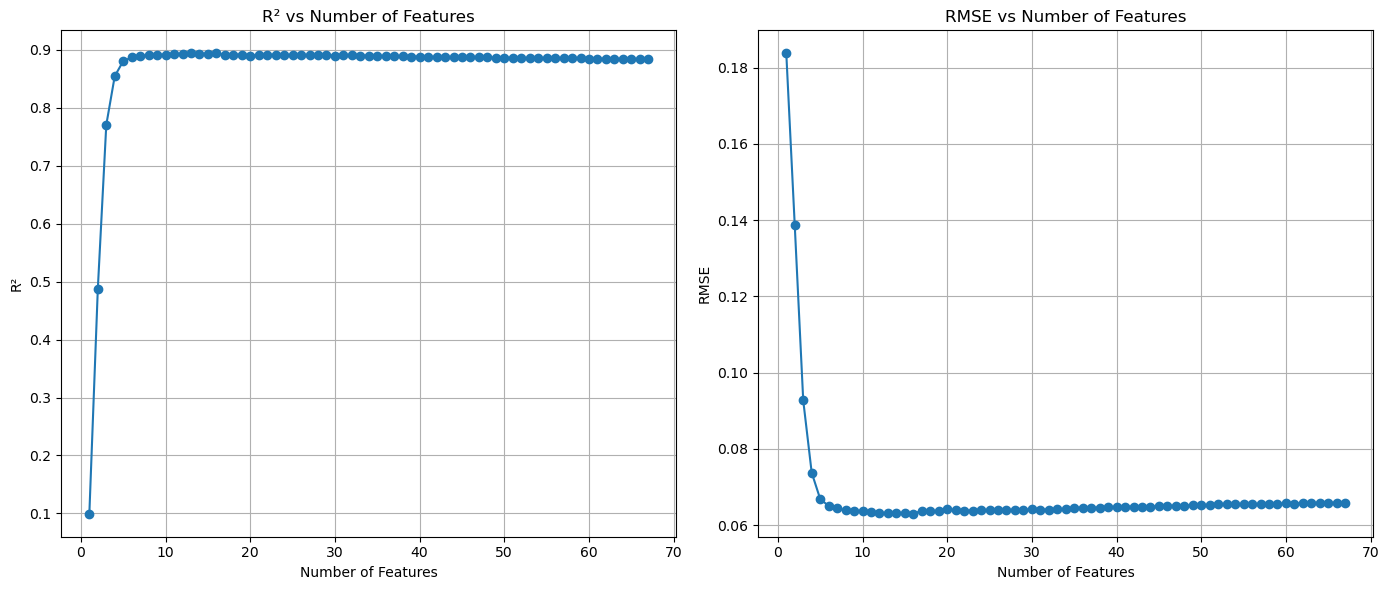

In [4]:
# Plot R² and RMSE vs number of features
num_features = range(len(terrain_attributes), 0, -1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(num_features, r2_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('R²')
plt.title('R² vs Number of Features')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_features, rmse_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# Create a DataFrame to show the kept features and corresponding R² values
results_df = pd.DataFrame({
    'Number of Features': num_features,
    'R²': r2_scores,
    'Kept Features': kept_features_list
})

# Display the DataFrame
results_df

,Number of Features,R²,Kept Features
0,67,0.884315,"[Aspect, Aspect_LP10, Aspect_LP30, Aspect_ss_5..."
1,66,0.884401,"[Aspect, Aspect_LP10, Aspect_LP30, Aspect_ss_5..."
2,65,0.884306,"[Aspect, Aspect_LP10, Aspect_LP30, Aspect_ss_5..."
3,64,0.884266,"[Aspect, Aspect_LP10, Aspect_LP30, Aspect_ss_5..."
4,63,0.884609,"[Aspect, Aspect_LP10, Aspect_LP30, Aspect_ss_5..."
...,...,...,...
62,5,0.880696,"[Aspect_LP30, LP30, PosOpen_LP30, Standardized..."
63,4,0.854864,"[Aspect_LP30, LP30, StandardizedHeight_LP10, T..."
64,3,0.770717,"[Aspect_LP30, LP30, TPI_LP30]"
65,2,0.487682,"[LP30, TPI_LP30]"


In [11]:
# Select the 8-variable model from the results_df
selected_features = results_df.loc[results_df['Number of Features'] == 5, 'Kept Features'].values[0]

# Prepare the data with the selected features
X_selected = data[selected_features]
y = data[target_variable]

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_selected = imputer.fit_transform(X_selected)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f'R² value for the model with 8 features: {r2}')

R² value for the model with 8 features: 0.8806958925060688


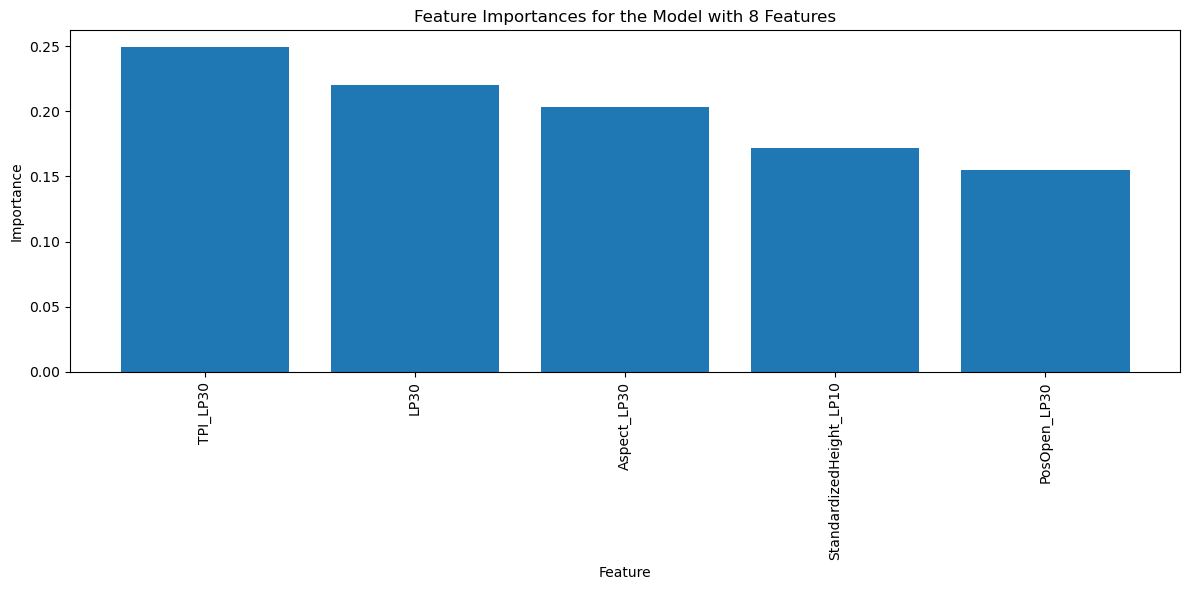

In [12]:
# Plot the feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [selected_features[i] for i in indices]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances for the Model with 8 Features')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

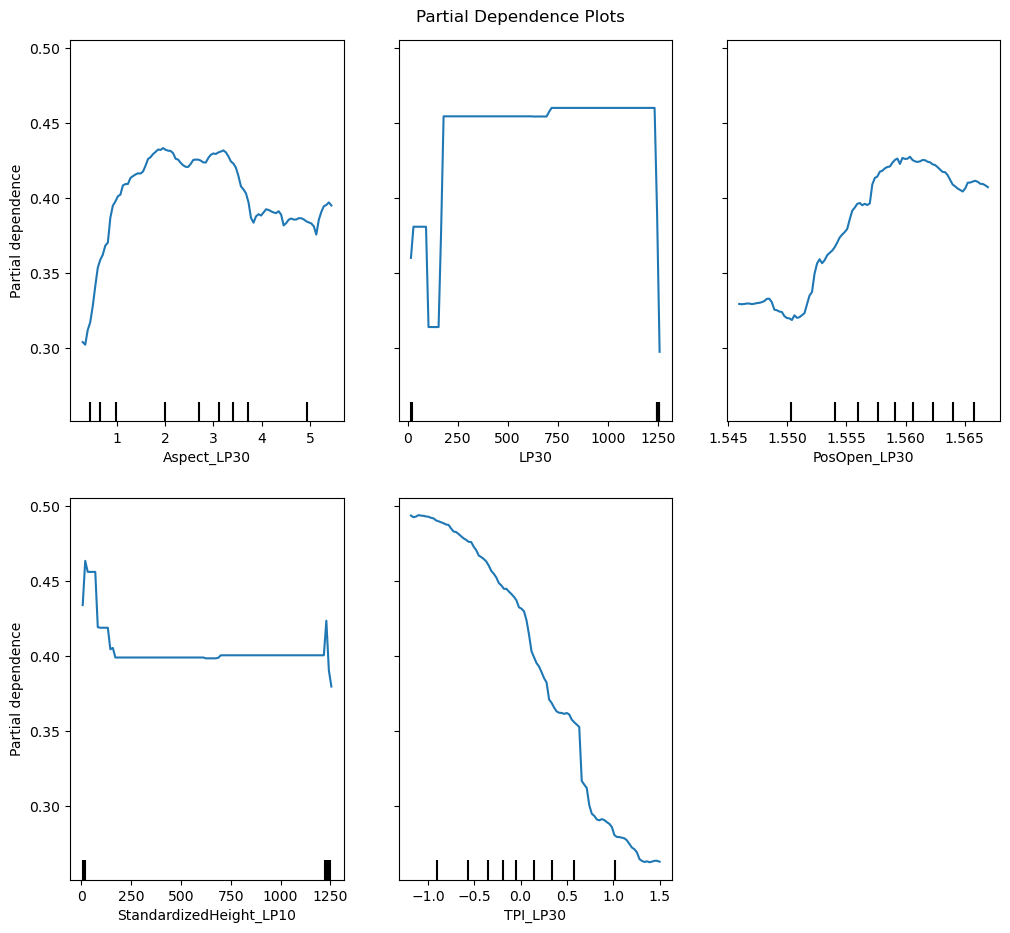

In [13]:
# Plot partial dependence plots for the selected features
fig, ax = plt.subplots(figsize=(12, 10))
display = PartialDependenceDisplay.from_estimator(rf, X_train, features=range(len(selected_features)), feature_names=selected_features, ax=ax)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.95)  # Adjust title position
plt.show()

In [14]:
selected_features

['Aspect_LP30', 'LP30', 'PosOpen_LP30', 'StandardizedHeight_LP10', 'TPI_LP30']